In [22]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

# Rule-based algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

import joblib

In [3]:
df = pd.read_excel('data.xlsx')
df.head()

,CustomerID,Name,Age,Email,EmploymentStatus,HousingStatus,ActiveMember,Country,EstimatedSalary,Balance,...,CustomerEngagementScore,TechSupportTicketCount,NumberOfAppCrashes,NavigationDifficulty,UserFrustration,CustomerSatisfactionSurvey,CustomerServiceCalls,NPS,Churn,Persona
0,15634602,Wyatt Miller,27,wyatt.miller47@gmail.com,0,1,1,Singapore,56424,85123.46,...,10,0,0,0,0,3,1,9,0,Opportunistic
1,15634603,Kathleen Coleman,27,kathleen.coleman79@gmail.com,0,1,1,Singapore,70079,51061.66,...,2,0,0,0,0,3,4,10,0,General
2,15634604,Mrs. Suzanne Torres MD,48,mrs..md62@gmail.com,1,1,1,Singapore,87211,86096.84,...,4,1,2,6,1,9,2,2,1,TechDifficulties
3,15634605,Christian Hoffman,64,christian.hoffman3@gmail.com,1,0,1,Singapore,79491,118453.65,...,9,0,0,0,0,8,2,7,0,Loyal
4,15634606,Marcus Henson,34,marcus.henson49@gmail.com,0,0,1,Singapore,73618,73389.26,...,10,2,2,6,1,10,1,6,0,TechDifficulties


clean data and data preprocessing

In [4]:
print("Available columns in dataset:", df.columns.tolist())
# Ensure 'Persona' column exists
data_cleaned = df.drop(columns=['CustomerID', 'Name', 'Email'])
# print("Columns after removing unnecessary ones:", data_cleaned.columns.tolist())
data_cleaned = data_cleaned[~data_cleaned['Persona'].isin([ 'Key Accounts'])]

X = data_cleaned.drop(columns='Persona')  # Drop the target variable from the features
y = data_cleaned['Persona']
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()


numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Create a column transformer to apply the transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
        ])

Available columns in dataset: ['CustomerID', 'Name', 'Age', 'Email', 'EmploymentStatus', 'HousingStatus', 'ActiveMember', 'Country', 'EstimatedSalary', 'Balance', 'Gender', 'ProductsNumber', 'DebitCard', 'SavingsAccount', 'FlexiLoan', 'Tenure', 'DaysSinceLastTransaction', 'CustomerEngagementScore', 'TechSupportTicketCount', 'NumberOfAppCrashes', 'NavigationDifficulty', 'UserFrustration', 'CustomerSatisfactionSurvey', 'CustomerServiceCalls', 'NPS', 'Churn', 'Persona']


In [5]:
X_preprocessed = preprocessor.fit_transform(X)
print(X_preprocessed)

[[-1.05808503 -1.90035992  0.82769113 ...  1.          0.
   1.        ]
 [-1.05808503 -1.90035992  0.82769113 ...  1.          1.
   0.        ]
 [ 0.31131103  0.52621611  0.82769113 ...  1.          1.
   0.        ]
 ...
 [-1.12329437  0.52621611  0.82769113 ...  1.          1.
   0.        ]
 [-1.44934105 -1.90035992 -1.20818015 ...  1.          1.
   0.        ]
 [-1.57975972  0.52621611  0.82769113 ...  1.          1.
   0.        ]]


rebalance data and build models 

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Shape of X after SMOTE:", X_train_resampled.shape)
print("Shape of y after SMOTE:", y_train_resampled.shape)

Shape of X after SMOTE: (9600, 25)
Shape of y after SMOTE: (9600,)


In [8]:
# Set random seed for reproducibility later on in hyperparameter tuning
random_seed = 42

# Initialize classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "Logistic Regression": LogisticRegression(random_state=random_seed),
    "Support Vector Machine": SVC(random_state=random_seed),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_seed)
    }

In [9]:
# Dictionary that stores evaluation metrics of models
'''
Key: Model name
Value: A list containing the following metrics:
  - True Positive Rate
  - False Positive Rate
  - True Negative Rate
  - False Negative Rate
  - F1 Score
  - ROC AUC Score
  - Precision Score
'''
model_results = {}

In [10]:
# Function to view classification report

def clf_report(model_name, y_pred):
    '''
    Prints the classification report of a model for multi-class classification.

    Inputs:
      model_name: name of the model
      y_pred: array of predicted class labels
    '''
    print(model_name)

    # Calculating scores for multi-class classification
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy score:", round(accuracy, 4))

    # Only calculate ROC AUC if y_pred is not just labels (requires probability scores)
    # print("ROC AUC score:", round(metrics.roc_auc_score(y_test, y_pred, average='macro', multi_class='ovo'), 4))

    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    print("F1 score:", round(f1, 4))

    # Confusion matrix
    matrix = metrics.confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(matrix)

    print(metrics.classification_report(y_test, y_pred))

    # Display the confusion matrix graphically
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot()
    plt.show()


1 2 3 4 5 6 7 8 9 

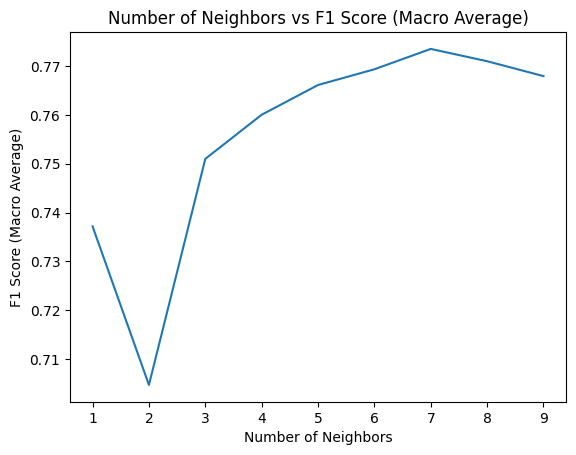

In [11]:
error = []  # This will store the average F1 scores for each k
k = range(1, 10)  # Testing k from 1 to 9

for i in k:
    print(i, end=" ")
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_resampled, y_train_resampled)  # Assuming X_train_resampled and y_train_resampled are correctly prepared
    y_pred = knn.predict(X_test)  # Predicting with the test set
    
    # Calculate the F1 score for multi-class classification
    # The 'average' parameter can be set to 'macro', 'micro', or 'weighted' depending on how you want to aggregate the scores
    # 'macro' averages the F1 scores of each class without taking label imbalance into account
    # 'micro' calculates the total true positives, false negatives, and false positives and computes a global F1 score
    # 'weighted' averages the F1 scores of each class, weighting them by the number of true instances for each class
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    error.append(f1)  # Append the calculated F1 score to the list

# Plotting the results
plt.plot(k, error)
plt.title('Number of Neighbors vs F1 Score (Macro Average)')
plt.xlabel('Number of Neighbors')
plt.ylabel('F1 Score (Macro Average)')
plt.show()

Random Forest
Accuracy score: 0.8722
F1 score: 0.8722
Confusion Matrix:
[[270   4   9   3   6   0]
 [  0 299   1   1   0   0]
 [  0   3 240  67  82   0]
 [  3   4   0 391   0   0]
 [ 11   3  58   0 213   0]
 [  0   0   0   0   0 328]]
                       precision    recall  f1-score   support

CustomerServiceIssues       0.95      0.92      0.94       292
  FinanciallyStrained       0.96      0.99      0.97       301
              General       0.78      0.61      0.69       392
                Loyal       0.85      0.98      0.91       398
        Opportunistic       0.71      0.75      0.73       285
     TechDifficulties       1.00      1.00      1.00       328

             accuracy                           0.87      1996
            macro avg       0.87      0.88      0.87      1996
         weighted avg       0.87      0.87      0.87      1996



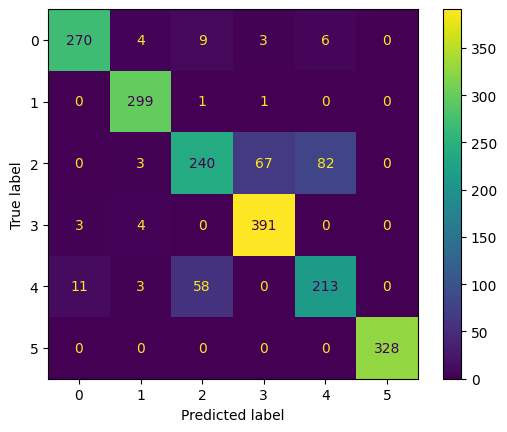

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Accuracy score: 0.8362
F1 score: 0.8396
Confusion Matrix:
[[260   2   9  11  10   0]
 [  0 296   1   3   1   0]
 [  3   7 230  82  70   0]
 [  7   5  26 357   3   0]
 [ 10   4  66   7 198   0]
 [  0   0   0   0   0 328]]
                       precision    recall  f1-score   support

CustomerServiceIssues       0.93      0.89      0.91       292
  FinanciallyStrained       0.94      0.98      0.96       301
              General       0.69      0.59      0.64       392
                Loyal       0.78      0.90      0.83       398
        Opportunistic       0.70      0.69      0.70       285
     TechDifficulties       1.00      1.00      1.00       328

             accuracy                           0.84      1996
            macro avg       0.84      0.84      0.84      1996
         weighted avg       0.83      0.84      0.83      1996



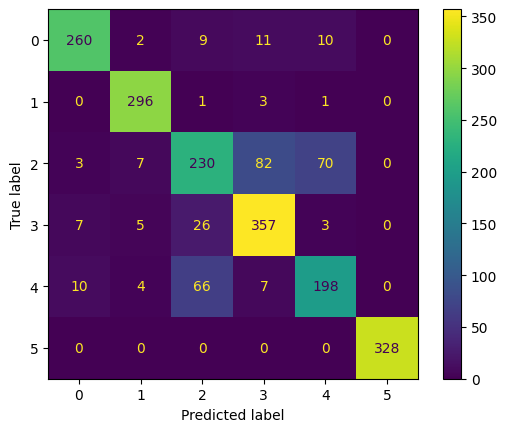


Support Vector Machine
Accuracy score: 0.8482
F1 score: 0.8483
Confusion Matrix:
[[257   3  12  12   8   0]
 [  0 300   0   1   0   0]
 [  0   8 217  91  76   0]
 [ 10   5   3 380   0   0]
 [ 13   6  53   2 211   0]
 [  0   0   0   0   0 328]]
                       precision    recall  f1-score   support

CustomerServiceIssues       0.92      0.88      0.90       292
  FinanciallyStrained       0.93      1.00      0.96       301
              General       0.76      0.55      0.64       392
                Loyal       0.78      0.95      0.86       398
        Opportunistic       0.72      0.74      0.73       285
     TechDifficulties       1.00      1.00      1.00       328

             accuracy                           0.85      1996
            macro avg       0.85      0.85      0.85      1996
         weighted avg       0.85      0.85      0.84      1996



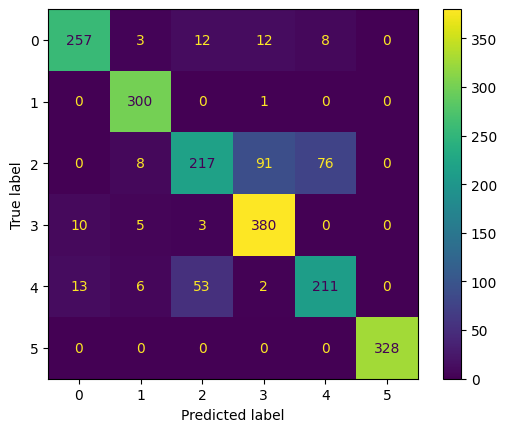


KNN
Accuracy score: 0.7796
F1 score: 0.7723
Confusion Matrix:
[[247  10  12  16   7   0]
 [  1 294   1   4   1   0]
 [  2  18 216 102  54   0]
 [ 11  12  24 351   0   0]
 [ 32  13 100  20 120   0]
 [  0   0   0   0   0 328]]
                       precision    recall  f1-score   support

CustomerServiceIssues       0.84      0.85      0.84       292
  FinanciallyStrained       0.85      0.98      0.91       301
              General       0.61      0.55      0.58       392
                Loyal       0.71      0.88      0.79       398
        Opportunistic       0.66      0.42      0.51       285
     TechDifficulties       1.00      1.00      1.00       328

             accuracy                           0.78      1996
            macro avg       0.78      0.78      0.77      1996
         weighted avg       0.77      0.78      0.77      1996



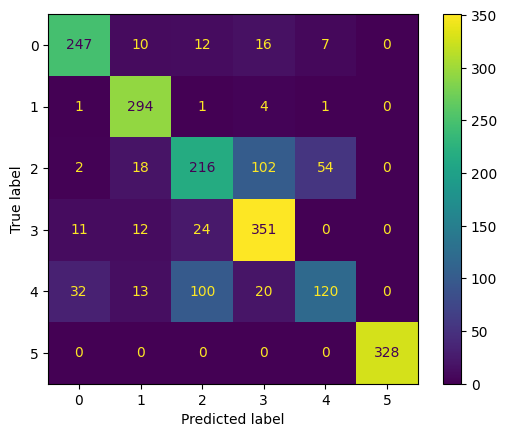


Gradient Boosting
Accuracy score: 0.8773
F1 score: 0.8769
Confusion Matrix:
[[272   3  11   3   3   0]
 [  0 300   1   0   0   0]
 [  0   4 218  67 103   0]
 [  3   3   0 392   0   0]
 [ 11   3  30   0 241   0]
 [  0   0   0   0   0 328]]
                       precision    recall  f1-score   support

CustomerServiceIssues       0.95      0.93      0.94       292
  FinanciallyStrained       0.96      1.00      0.98       301
              General       0.84      0.56      0.67       392
                Loyal       0.85      0.98      0.91       398
        Opportunistic       0.69      0.85      0.76       285
     TechDifficulties       1.00      1.00      1.00       328

             accuracy                           0.88      1996
            macro avg       0.88      0.89      0.88      1996
         weighted avg       0.88      0.88      0.87      1996



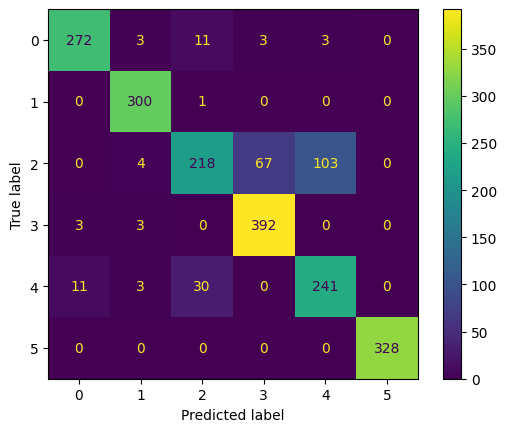

In [12]:
# Train each model
for name, clf in classifiers.items():
    # Train the model
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test)

    # Evaluate the model
    clf_report(name, y_pred)
    print()

    # Separator
    print(''.join(['='] * 60))
    print(''.join(['='] * 60))

gradient boosting hyperparameter tuning 


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[CV 4/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.852 total time=  12.8s
[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.863 total time=  12.8s
[CV 2/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.852 total time=  13.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.870 total time=  13.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.874 total time=  13.2s
[CV 2/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0;, score=0.852 total time=  15.3s
[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n

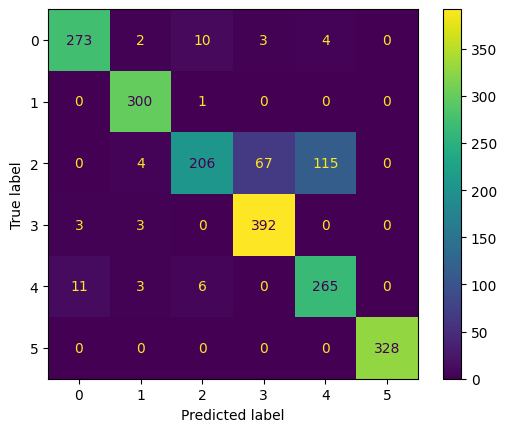

In [23]:
np.random.seed(42)
param_grid = {
    "Gradient Boosting": {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'subsample': [0.8, 1.0]
}
}
classifiers_2 = {
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_seed)
    }
for name, clf in classifiers_2.items():
    param_grid = param_grid[name]
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3) # parallelize the hyperparameter search to make it faster
    grid_search.fit(X_train, y_train)

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    best_clf = grid_search.best_estimator_
    # Optionally save the best model
    joblib.dump(best_clf, f'{name}_best_model.pkl')

    # Print the parameters of the best model
    print(f"Parameters of the best model: {best_clf.get_params()}")

    # Evaluate the best model
    y_pred = best_clf.predict(X_test)
    clf_report(name, y_pred)
    print()

    # Separator
    print(''.join(['='] * 60))
    print(''.join(['='] * 60))


deep learning model - feed forward neuralnetwork 

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
encoder = LabelEncoder()

# Fit the encoder to the training data and transform both training and test data
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)
# Define the model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(set(y)), activation='softmax')  # Output layer: one neuron per class
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with integer-encoded labels
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Deep Learning Model Accuracy: {accuracy}")

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step - accuracy: 0.3796 - loss: 1.5184 - val_accuracy: 0.7746 - val_loss: 0.5573
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - accuracy: 0.7116 - loss: 0.7304 - val_accuracy: 0.8053 - val_loss: 0.4455
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.7484 - loss: 0.5963 - val_accuracy: 0.8341 - val_loss: 0.4157
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - accuracy: 0.7786 - loss: 0.5478 - val_accuracy: 0.8247 - val_loss: 0.3990
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.8043 - loss: 0.4834 - val_accuracy: 0.8322 - val_loss: 0.3949
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.8037 - loss: 0.4772 - val_accuracy: 0.8322 - val_loss: 0.3838
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 705us/step - accuracy: 0.7895 - loss: 0.4949 - val_accuracy: 0.8353 - val_loss: 0.3791
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - accuracy: 0.8099 - loss: 0.4533 - val_accurac

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define a function to create and compile the model with given hyperparameters
def create_and_compile_model(learning_rate, dropout_rate):
    model = Sequential([
        Dense(128, activation='relu', input_dim=X_train.shape[1]),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(len(set(y_train_encoded)), activation='softmax')  # Using set on y_train_encoded to count unique classes
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define your hyperparameters to test
learning_rates = [0.001, 0.01, 0.1]
dropout_rates = [0.3, 0.5, 0.7]
epochs = 50
batch_size = 32

# Manual grid search
best_score = 0
best_params = {}

for lr in learning_rates:
    for dr in dropout_rates:
        print(f"Testing model with learning rate: {lr} and dropout rate: {dr}")
        model = create_and_compile_model(lr, dr)
        history = model.fit(X_train, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
        val_accuracy = max(history.history['val_accuracy'])
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        
        if val_accuracy > best_score:
            best_score = val_accuracy
            best_params = {'learning_rate': lr, 'dropout_rate': dr}


Testing model with learning rate: 0.001 and dropout rate: 0.3
Validation Accuracy: 0.8647
Testing model with learning rate: 0.001 and dropout rate: 0.5
Validation Accuracy: 0.8704
Testing model with learning rate: 0.001 and dropout rate: 0.7
Validation Accuracy: 0.8597
Testing model with learning rate: 0.01 and dropout rate: 0.3
Validation Accuracy: 0.8560
Testing model with learning rate: 0.01 and dropout rate: 0.5
Validation Accuracy: 0.8478
Testing model with learning rate: 0.01 and dropout rate: 0.7
Validation Accuracy: 0.8322
Testing model with learning rate: 0.1 and dropout rate: 0.3
Validation Accuracy: 0.3694
Testing model with learning rate: 0.1 and dropout rate: 0.5
Validation Accuracy: 0.3694
Testing model with learning rate: 0.1 and dropout rate: 0.7
Validation Accuracy: 0.3694


In [15]:

print("Best Validation Accuracy: {:.4f}".format(best_score))
print("Best Parameters:", best_params)


Best Validation Accuracy: 0.8704
Best Parameters: {'learning_rate': 0.001, 'dropout_rate': 0.5}
